In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)

import mlflow

2.7.0


In [5]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from linear_benchmark import QuantileLossModel, model_linear
from chart_tools import loss_figure, train_dist_figure, test_dist_figure, get_cycle
from sample_creation import sample_creation, created_naive_forecast, import_latest_data, import_data, invert_scale, invert_normalize

In [6]:
#from sstudentt import SST
from scipy import optimize

In [7]:
def return_density(cond_quant):
    initial_estimates = np.array([1., 1., 1., 3.])

    parameters_est = optimize.leastsq(opt, initial_estimates, (cond_quant, ))

    #print(parameters_est)

    dist_result = SST( 
                  mu = parameters_est[0][0], 
                  sigma = parameters_est[0][1], 
                  nu = parameters_est[0][2],
                  tau = parameters_est[0][3]
                  )

    return dist_result, parameters_est

def opt(parameters, data):
    quantiles_config = [
             0.05,
             0.25,
             0.75,
             0.95]
    dist = SST(mu = parameters[0], sigma = parameters[1], nu = parameters[2], tau = parameters[3])
    error = dist.q(quantiles_config) - data
    return error

In [8]:
def generate_quantiles(num_quantiles):
    '''
    Create equally spaced quantiles
    '''
    return np.linspace(0.01, 0.99 , num_quantiles).tolist()

In [9]:
# Define the model parameters
param = {
    'NUM_FEATURES': 0,
    'NUM_QUANTILES': 7,
    'SPLIT': 0.75,
    'WINDOW_SIZE': 1,
    '1_COMMON_LSTM_NUM': 128,
    '2_COMMON_LSTM_NUM': 64,
    '1_IND_LSTM_NUM': 64,
    '1_IND_DENSE_NUM': 32,
    '1_IND_DENSE_ACTIVATION': 'relu',
    '1_OUT_DENSE_ACTIVATION': None,
    '1_LEARNING_RATE': 0.001,
    '2_SELECTION_METHOD': "weights", # "weights", "softmax_relu"
    '2_LSTM_NUM': 32,
    '2_DENSE_1_NUM': 16,
    '2_DENSE_1_ACTIVATION': None,
    '2_DENSE_2_ACTIVATION': 'tanh',
    '2_LEARNING_RATE': 0.001,
    'PRED_STEP': 1
}

EPOCHS1 = 1000
EPOCHS2 = 1000

# Generate quantiles
#param['QUANTILES'] = generate_quantiles(param['NUM_QUANTILES'])
param['QUANTILES'] = [0.05, 0.25, 0.75, 0.95]

CALLBACKS = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=50)

In [11]:
country = "Lithuania"

# Import and generate modeling sample
#dataset = import_latest_data()

datafile = "data_"+country+"_19.07.2022.csv"

dataset = import_data(datafile)

# exclude risk factors
# dataset = dataset.drop(['EXT_DEM'], axis=1)
# dataset = dataset.drop(['DAX_Volume'], axis=1)
# dataset = dataset.drop(['SENTIMENT'], axis=1)

# leave only gdp
#dataset = dataset['GDP']
dataset = dataset[['GDP', 'SENTIMENT', 'LT_BOND_YIELD']]

data, scaler = sample_creation(dataset, param, prediction_step = param['PRED_STEP'])

naive = created_naive_forecast(data['TEST_DF'], param['WINDOW_SIZE'])
if isinstance(dataset, pd.DataFrame):
    param['NUM_FEATURES'] = data['TRAIN_DF'].shape[1]
else:
    param['NUM_FEATURES'] = 1

data/data_Lithuania_19.07.2022.csv


In [12]:
# Estimate the models
y_train_dist, y_test_dist, history1, model1 = model_linear(param, data, EPOCHS1)

Epoch 1/1000
Cause: could not parse the source code of <function QuantileLossModel.create_linear_model.<locals>.<lambda> at 0x28de4d790>: no matching AST found among candidates:
# coding=utf-8
lambda y, f: multi_tilted_loss(self._quantiles, y, f)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: could not parse the source code of <function QuantileLossModel.create_linear_model.<locals>.<lambda> at 0x28de4d790>: no matching AST found among candidates:
# coding=utf-8
lambda y, f: multi_tilted_loss(self._quantiles, y, f)
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


2022-08-18 13:57:40.547433: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


2/2 - 0s - loss: 3.3490 - mae: 0.9331 - mse: 2.6464 - val_loss: 7.9060 - val_mae: 1.8083 - val_mse: 13.7760 - 466ms/epoch - 233ms/step
Epoch 2/1000
2/2 - 0s - loss: 3.3392 - mae: 0.9321 - mse: 2.6414 - val_loss: 7.8921 - val_mae: 1.8076 - val_mse: 13.7425 - 8ms/epoch - 4ms/step
Epoch 3/1000
2/2 - 0s - loss: 3.3304 - mae: 0.9314 - mse: 2.6374 - val_loss: 7.8782 - val_mae: 1.8066 - val_mse: 13.7097 - 9ms/epoch - 4ms/step
Epoch 4/1000
2/2 - 0s - loss: 3.3216 - mae: 0.9307 - mse: 2.6335 - val_loss: 7.8641 - val_mae: 1.8055 - val_mse: 13.6786 - 9ms/epoch - 4ms/step
Epoch 5/1000
2/2 - 0s - loss: 3.3128 - mae: 0.9300 - mse: 2.6298 - val_loss: 7.8498 - val_mae: 1.8043 - val_mse: 13.6464 - 9ms/epoch - 4ms/step
Epoch 6/1000
2/2 - 0s - loss: 3.3041 - mae: 0.9293 - mse: 2.6261 - val_loss: 7.8360 - val_mae: 1.8031 - val_mse: 13.6144 - 8ms/epoch - 4ms/step
Epoch 7/1000
2/2 - 0s - loss: 3.2952 - mae: 0.9285 - mse: 2.6221 - val_loss: 7.8212 - val_mae: 1.8016 - val_mse: 13.5793 - 10ms/epoch - 5ms/step


Epoch 58/1000
2/2 - 0s - loss: 2.9222 - mae: 0.8948 - mse: 2.4262 - val_loss: 7.1377 - val_mae: 1.7162 - val_mse: 11.9261 - 8ms/epoch - 4ms/step
Epoch 59/1000
2/2 - 0s - loss: 2.9155 - mae: 0.8944 - mse: 2.4230 - val_loss: 7.1245 - val_mae: 1.7147 - val_mse: 11.8936 - 9ms/epoch - 4ms/step
Epoch 60/1000
2/2 - 0s - loss: 2.9085 - mae: 0.8939 - mse: 2.4198 - val_loss: 7.1113 - val_mae: 1.7131 - val_mse: 11.8610 - 8ms/epoch - 4ms/step
Epoch 61/1000
2/2 - 0s - loss: 2.9013 - mae: 0.8932 - mse: 2.4157 - val_loss: 7.0985 - val_mae: 1.7116 - val_mse: 11.8292 - 8ms/epoch - 4ms/step
Epoch 62/1000
2/2 - 0s - loss: 2.8944 - mae: 0.8926 - mse: 2.4118 - val_loss: 7.0860 - val_mae: 1.7101 - val_mse: 11.7984 - 9ms/epoch - 4ms/step
Epoch 63/1000
2/2 - 0s - loss: 2.8875 - mae: 0.8920 - mse: 2.4075 - val_loss: 7.0735 - val_mae: 1.7085 - val_mse: 11.7675 - 9ms/epoch - 5ms/step
Epoch 64/1000
2/2 - 0s - loss: 2.8808 - mae: 0.8914 - mse: 2.4037 - val_loss: 7.0605 - val_mae: 1.7067 - val_mse: 11.7355 - 8ms/ep

Epoch 115/1000
2/2 - 0s - loss: 2.5992 - mae: 0.8719 - mse: 2.2647 - val_loss: 6.5293 - val_mae: 1.6429 - val_mse: 10.4606 - 9ms/epoch - 4ms/step
Epoch 116/1000
2/2 - 0s - loss: 2.5940 - mae: 0.8715 - mse: 2.2620 - val_loss: 6.5193 - val_mae: 1.6417 - val_mse: 10.4367 - 8ms/epoch - 4ms/step
Epoch 117/1000
2/2 - 0s - loss: 2.5889 - mae: 0.8712 - mse: 2.2595 - val_loss: 6.5099 - val_mae: 1.6406 - val_mse: 10.4143 - 8ms/epoch - 4ms/step
Epoch 118/1000
2/2 - 0s - loss: 2.5839 - mae: 0.8709 - mse: 2.2572 - val_loss: 6.5012 - val_mae: 1.6396 - val_mse: 10.3943 - 8ms/epoch - 4ms/step
Epoch 119/1000
2/2 - 0s - loss: 2.5790 - mae: 0.8706 - mse: 2.2550 - val_loss: 6.4923 - val_mae: 1.6386 - val_mse: 10.3746 - 8ms/epoch - 4ms/step
Epoch 120/1000
2/2 - 0s - loss: 2.5740 - mae: 0.8703 - mse: 2.2527 - val_loss: 6.4831 - val_mae: 1.6376 - val_mse: 10.3543 - 9ms/epoch - 4ms/step
Epoch 121/1000
2/2 - 0s - loss: 2.5688 - mae: 0.8700 - mse: 2.2503 - val_loss: 6.4745 - val_mae: 1.6367 - val_mse: 10.3352 -

Epoch 172/1000
2/2 - 0s - loss: 2.2915 - mae: 0.8496 - mse: 2.1161 - val_loss: 5.9961 - val_mae: 1.5825 - val_mse: 9.2314 - 9ms/epoch - 4ms/step
Epoch 173/1000
2/2 - 0s - loss: 2.2848 - mae: 0.8491 - mse: 2.1128 - val_loss: 5.9877 - val_mae: 1.5819 - val_mse: 9.2121 - 8ms/epoch - 4ms/step
Epoch 174/1000
2/2 - 0s - loss: 2.2786 - mae: 0.8487 - mse: 2.1099 - val_loss: 5.9788 - val_mae: 1.5812 - val_mse: 9.1913 - 9ms/epoch - 5ms/step
Epoch 175/1000
2/2 - 0s - loss: 2.2726 - mae: 0.8482 - mse: 2.1070 - val_loss: 5.9663 - val_mae: 1.5797 - val_mse: 9.1613 - 8ms/epoch - 4ms/step
Epoch 176/1000
2/2 - 0s - loss: 2.2658 - mae: 0.8475 - mse: 2.1033 - val_loss: 5.9485 - val_mae: 1.5768 - val_mse: 9.1183 - 9ms/epoch - 4ms/step
Epoch 177/1000
2/2 - 0s - loss: 2.2583 - mae: 0.8466 - mse: 2.0989 - val_loss: 5.9299 - val_mae: 1.5738 - val_mse: 9.0735 - 8ms/epoch - 4ms/step
Epoch 178/1000
2/2 - 0s - loss: 2.2502 - mae: 0.8455 - mse: 2.0936 - val_loss: 5.9117 - val_mae: 1.5708 - val_mse: 9.0303 - 8ms/ep

Epoch 229/1000
2/2 - 0s - loss: 2.0085 - mae: 0.8289 - mse: 1.9839 - val_loss: 5.4433 - val_mae: 1.5177 - val_mse: 7.9757 - 8ms/epoch - 4ms/step
Epoch 230/1000
2/2 - 0s - loss: 2.0023 - mae: 0.8282 - mse: 1.9807 - val_loss: 5.4284 - val_mae: 1.5158 - val_mse: 7.9425 - 9ms/epoch - 4ms/step
Epoch 231/1000
2/2 - 0s - loss: 1.9963 - mae: 0.8277 - mse: 1.9777 - val_loss: 5.4137 - val_mae: 1.5140 - val_mse: 7.9102 - 7ms/epoch - 4ms/step
Epoch 232/1000
2/2 - 0s - loss: 1.9906 - mae: 0.8272 - mse: 1.9749 - val_loss: 5.4003 - val_mae: 1.5123 - val_mse: 7.8805 - 9ms/epoch - 4ms/step
Epoch 233/1000
2/2 - 0s - loss: 1.9853 - mae: 0.8268 - mse: 1.9723 - val_loss: 5.3883 - val_mae: 1.5108 - val_mse: 7.8537 - 8ms/epoch - 4ms/step
Epoch 234/1000
2/2 - 0s - loss: 1.9802 - mae: 0.8264 - mse: 1.9700 - val_loss: 5.3777 - val_mae: 1.5094 - val_mse: 7.8300 - 9ms/epoch - 4ms/step
Epoch 235/1000
2/2 - 0s - loss: 1.9754 - mae: 0.8260 - mse: 1.9678 - val_loss: 5.3677 - val_mae: 1.5082 - val_mse: 7.8078 - 8ms/ep

Epoch 286/1000
2/2 - 0s - loss: 1.8102 - mae: 0.8127 - mse: 1.8855 - val_loss: 5.0287 - val_mae: 1.4705 - val_mse: 7.0971 - 8ms/epoch - 4ms/step
Epoch 287/1000
2/2 - 0s - loss: 1.8074 - mae: 0.8124 - mse: 1.8839 - val_loss: 5.0232 - val_mae: 1.4698 - val_mse: 7.0851 - 8ms/epoch - 4ms/step
Epoch 288/1000
2/2 - 0s - loss: 1.8047 - mae: 0.8121 - mse: 1.8823 - val_loss: 5.0177 - val_mae: 1.4690 - val_mse: 7.0734 - 9ms/epoch - 5ms/step
Epoch 289/1000
2/2 - 0s - loss: 1.8021 - mae: 0.8118 - mse: 1.8808 - val_loss: 5.0122 - val_mae: 1.4683 - val_mse: 7.0616 - 9ms/epoch - 5ms/step
Epoch 290/1000
2/2 - 0s - loss: 1.7996 - mae: 0.8115 - mse: 1.8794 - val_loss: 5.0067 - val_mae: 1.4675 - val_mse: 7.0499 - 8ms/epoch - 4ms/step
Epoch 291/1000
2/2 - 0s - loss: 1.7972 - mae: 0.8112 - mse: 1.8780 - val_loss: 5.0013 - val_mae: 1.4667 - val_mse: 7.0382 - 9ms/epoch - 4ms/step
Epoch 292/1000
2/2 - 0s - loss: 1.7948 - mae: 0.8109 - mse: 1.8767 - val_loss: 4.9957 - val_mae: 1.4660 - val_mse: 7.0263 - 9ms/ep

Epoch 343/1000
2/2 - 0s - loss: 1.6616 - mae: 0.7961 - mse: 1.8076 - val_loss: 4.6167 - val_mae: 1.4099 - val_mse: 6.2679 - 7ms/epoch - 4ms/step
Epoch 344/1000
2/2 - 0s - loss: 1.6591 - mae: 0.7959 - mse: 1.8066 - val_loss: 4.6086 - val_mae: 1.4089 - val_mse: 6.2525 - 8ms/epoch - 4ms/step
Epoch 345/1000
2/2 - 0s - loss: 1.6563 - mae: 0.7957 - mse: 1.8055 - val_loss: 4.6003 - val_mae: 1.4080 - val_mse: 6.2367 - 9ms/epoch - 4ms/step
Epoch 346/1000
2/2 - 0s - loss: 1.6535 - mae: 0.7955 - mse: 1.8045 - val_loss: 4.5927 - val_mae: 1.4070 - val_mse: 6.2224 - 9ms/epoch - 4ms/step
Epoch 347/1000
2/2 - 0s - loss: 1.6509 - mae: 0.7953 - mse: 1.8034 - val_loss: 4.5852 - val_mae: 1.4061 - val_mse: 6.2082 - 8ms/epoch - 4ms/step
Epoch 348/1000
2/2 - 0s - loss: 1.6483 - mae: 0.7950 - mse: 1.8023 - val_loss: 4.5770 - val_mae: 1.4051 - val_mse: 6.1928 - 9ms/epoch - 4ms/step
Epoch 349/1000
2/2 - 0s - loss: 1.6454 - mae: 0.7948 - mse: 1.8011 - val_loss: 4.5682 - val_mae: 1.4041 - val_mse: 6.1764 - 8ms/ep

Epoch 400/1000
2/2 - 0s - loss: 1.5253 - mae: 0.7829 - mse: 1.7386 - val_loss: 4.2444 - val_mae: 1.3582 - val_mse: 5.5573 - 8ms/epoch - 4ms/step
Epoch 401/1000
2/2 - 0s - loss: 1.5230 - mae: 0.7827 - mse: 1.7377 - val_loss: 4.2364 - val_mae: 1.3570 - val_mse: 5.5429 - 9ms/epoch - 5ms/step
Epoch 402/1000
2/2 - 0s - loss: 1.5205 - mae: 0.7825 - mse: 1.7367 - val_loss: 4.2273 - val_mae: 1.3556 - val_mse: 5.5264 - 8ms/epoch - 4ms/step
Epoch 403/1000
2/2 - 0s - loss: 1.5176 - mae: 0.7823 - mse: 1.7355 - val_loss: 4.2184 - val_mae: 1.3542 - val_mse: 5.5101 - 9ms/epoch - 5ms/step
Epoch 404/1000
2/2 - 0s - loss: 1.5148 - mae: 0.7820 - mse: 1.7343 - val_loss: 4.2084 - val_mae: 1.3526 - val_mse: 5.4908 - 8ms/epoch - 4ms/step
Epoch 405/1000
2/2 - 0s - loss: 1.5114 - mae: 0.7816 - mse: 1.7325 - val_loss: 4.1984 - val_mae: 1.3509 - val_mse: 5.4711 - 8ms/epoch - 4ms/step
Epoch 406/1000
2/2 - 0s - loss: 1.5075 - mae: 0.7812 - mse: 1.7302 - val_loss: 4.1895 - val_mae: 1.3495 - val_mse: 5.4539 - 8ms/ep

Epoch 457/1000
2/2 - 0s - loss: 1.3712 - mae: 0.7628 - mse: 1.6506 - val_loss: 3.7809 - val_mae: 1.2799 - val_mse: 4.7119 - 8ms/epoch - 4ms/step
Epoch 458/1000
2/2 - 0s - loss: 1.3696 - mae: 0.7626 - mse: 1.6496 - val_loss: 3.7765 - val_mae: 1.2792 - val_mse: 4.7045 - 8ms/epoch - 4ms/step
Epoch 459/1000
2/2 - 0s - loss: 1.3680 - mae: 0.7624 - mse: 1.6487 - val_loss: 3.7723 - val_mae: 1.2784 - val_mse: 4.6974 - 8ms/epoch - 4ms/step
Epoch 460/1000
2/2 - 0s - loss: 1.3665 - mae: 0.7622 - mse: 1.6479 - val_loss: 3.7681 - val_mae: 1.2777 - val_mse: 4.6907 - 8ms/epoch - 4ms/step
Epoch 461/1000
2/2 - 0s - loss: 1.3650 - mae: 0.7619 - mse: 1.6470 - val_loss: 3.7640 - val_mae: 1.2771 - val_mse: 4.6842 - 8ms/epoch - 4ms/step
Epoch 462/1000
2/2 - 0s - loss: 1.3636 - mae: 0.7618 - mse: 1.6463 - val_loss: 3.7598 - val_mae: 1.2764 - val_mse: 4.6774 - 10ms/epoch - 5ms/step
Epoch 463/1000
2/2 - 0s - loss: 1.3621 - mae: 0.7616 - mse: 1.6454 - val_loss: 3.7555 - val_mae: 1.2756 - val_mse: 4.6703 - 8ms/e

Epoch 514/1000
2/2 - 0s - loss: 1.2390 - mae: 0.7486 - mse: 1.5793 - val_loss: 3.4234 - val_mae: 1.2250 - val_mse: 4.1235 - 8ms/epoch - 4ms/step
Epoch 515/1000
2/2 - 0s - loss: 1.2358 - mae: 0.7483 - mse: 1.5770 - val_loss: 3.4165 - val_mae: 1.2238 - val_mse: 4.1113 - 8ms/epoch - 4ms/step
Epoch 516/1000
2/2 - 0s - loss: 1.2329 - mae: 0.7479 - mse: 1.5751 - val_loss: 3.4091 - val_mae: 1.2224 - val_mse: 4.0980 - 9ms/epoch - 5ms/step
Epoch 517/1000
2/2 - 0s - loss: 1.2294 - mae: 0.7475 - mse: 1.5725 - val_loss: 3.4020 - val_mae: 1.2212 - val_mse: 4.0859 - 9ms/epoch - 4ms/step
Epoch 518/1000
2/2 - 0s - loss: 1.2264 - mae: 0.7471 - mse: 1.5703 - val_loss: 3.3951 - val_mae: 1.2200 - val_mse: 4.0748 - 8ms/epoch - 4ms/step
Epoch 519/1000
2/2 - 0s - loss: 1.2237 - mae: 0.7468 - mse: 1.5685 - val_loss: 3.3889 - val_mae: 1.2190 - val_mse: 4.0648 - 8ms/epoch - 4ms/step
Epoch 520/1000
2/2 - 0s - loss: 1.2212 - mae: 0.7465 - mse: 1.5669 - val_loss: 3.3825 - val_mae: 1.2179 - val_mse: 4.0545 - 8ms/ep

Epoch 571/1000
2/2 - 0s - loss: 1.1199 - mae: 0.7325 - mse: 1.5068 - val_loss: 3.0978 - val_mae: 1.1696 - val_mse: 3.6122 - 8ms/epoch - 4ms/step
Epoch 572/1000
2/2 - 0s - loss: 1.1183 - mae: 0.7322 - mse: 1.5059 - val_loss: 3.0922 - val_mae: 1.1686 - val_mse: 3.6036 - 8ms/epoch - 4ms/step
Epoch 573/1000
2/2 - 0s - loss: 1.1167 - mae: 0.7320 - mse: 1.5050 - val_loss: 3.0865 - val_mae: 1.1676 - val_mse: 3.5951 - 8ms/epoch - 4ms/step
Epoch 574/1000
2/2 - 0s - loss: 1.1152 - mae: 0.7318 - mse: 1.5042 - val_loss: 3.0812 - val_mae: 1.1667 - val_mse: 3.5873 - 9ms/epoch - 5ms/step
Epoch 575/1000
2/2 - 0s - loss: 1.1137 - mae: 0.7316 - mse: 1.5034 - val_loss: 3.0763 - val_mae: 1.1658 - val_mse: 3.5799 - 8ms/epoch - 4ms/step
Epoch 576/1000
2/2 - 0s - loss: 1.1123 - mae: 0.7313 - mse: 1.5026 - val_loss: 3.0714 - val_mae: 1.1649 - val_mse: 3.5726 - 9ms/epoch - 4ms/step
Epoch 577/1000
2/2 - 0s - loss: 1.1109 - mae: 0.7311 - mse: 1.5018 - val_loss: 3.0667 - val_mae: 1.1640 - val_mse: 3.5656 - 8ms/ep

Epoch 628/1000
2/2 - 0s - loss: 1.0386 - mae: 0.7218 - mse: 1.4646 - val_loss: 2.8554 - val_mae: 1.1293 - val_mse: 3.2681 - 8ms/epoch - 4ms/step
Epoch 629/1000
2/2 - 0s - loss: 1.0368 - mae: 0.7217 - mse: 1.4638 - val_loss: 2.8514 - val_mae: 1.1288 - val_mse: 3.2629 - 8ms/epoch - 4ms/step
Epoch 630/1000
2/2 - 0s - loss: 1.0351 - mae: 0.7216 - mse: 1.4630 - val_loss: 2.8434 - val_mae: 1.1274 - val_mse: 3.2522 - 8ms/epoch - 4ms/step
Epoch 631/1000
2/2 - 0s - loss: 1.0327 - mae: 0.7215 - mse: 1.4617 - val_loss: 2.8322 - val_mae: 1.1254 - val_mse: 3.2374 - 9ms/epoch - 4ms/step
Epoch 632/1000
2/2 - 0s - loss: 1.0296 - mae: 0.7212 - mse: 1.4599 - val_loss: 2.8224 - val_mae: 1.1236 - val_mse: 3.2243 - 8ms/epoch - 4ms/step
Epoch 633/1000
2/2 - 0s - loss: 1.0269 - mae: 0.7209 - mse: 1.4584 - val_loss: 2.8136 - val_mae: 1.1219 - val_mse: 3.2126 - 8ms/epoch - 4ms/step
Epoch 634/1000
2/2 - 0s - loss: 1.0245 - mae: 0.7207 - mse: 1.4570 - val_loss: 2.8058 - val_mae: 1.1205 - val_mse: 3.2023 - 8ms/ep

Epoch 685/1000
2/2 - 0s - loss: 0.9298 - mae: 0.7118 - mse: 1.4179 - val_loss: 2.4835 - val_mae: 1.0651 - val_mse: 2.7732 - 9ms/epoch - 4ms/step
Epoch 686/1000
2/2 - 0s - loss: 0.9283 - mae: 0.7116 - mse: 1.4170 - val_loss: 2.4789 - val_mae: 1.0643 - val_mse: 2.7668 - 9ms/epoch - 4ms/step
Epoch 687/1000
2/2 - 0s - loss: 0.9269 - mae: 0.7115 - mse: 1.4162 - val_loss: 2.4745 - val_mae: 1.0635 - val_mse: 2.7608 - 9ms/epoch - 4ms/step
Epoch 688/1000
2/2 - 0s - loss: 0.9255 - mae: 0.7114 - mse: 1.4154 - val_loss: 2.4687 - val_mae: 1.0624 - val_mse: 2.7530 - 9ms/epoch - 4ms/step
Epoch 689/1000
2/2 - 0s - loss: 0.9242 - mae: 0.7113 - mse: 1.4146 - val_loss: 2.4620 - val_mae: 1.0611 - val_mse: 2.7441 - 8ms/epoch - 4ms/step
Epoch 690/1000
2/2 - 0s - loss: 0.9227 - mae: 0.7112 - mse: 1.4138 - val_loss: 2.4561 - val_mae: 1.0600 - val_mse: 2.7361 - 7ms/epoch - 4ms/step
Epoch 691/1000
2/2 - 0s - loss: 0.9214 - mae: 0.7111 - mse: 1.4130 - val_loss: 2.4501 - val_mae: 1.0589 - val_mse: 2.7280 - 8ms/ep

Epoch 742/1000
2/2 - 0s - loss: 0.8564 - mae: 0.7047 - mse: 1.3738 - val_loss: 2.1605 - val_mae: 1.0024 - val_mse: 2.3715 - 8ms/epoch - 4ms/step
Epoch 743/1000
2/2 - 0s - loss: 0.8550 - mae: 0.7046 - mse: 1.3731 - val_loss: 2.1555 - val_mae: 1.0015 - val_mse: 2.3653 - 8ms/epoch - 4ms/step
Epoch 744/1000
2/2 - 0s - loss: 0.8533 - mae: 0.7045 - mse: 1.3725 - val_loss: 2.1518 - val_mae: 1.0010 - val_mse: 2.3607 - 8ms/epoch - 4ms/step
Epoch 745/1000
2/2 - 0s - loss: 0.8513 - mae: 0.7045 - mse: 1.3720 - val_loss: 2.1460 - val_mae: 1.0001 - val_mse: 2.3540 - 9ms/epoch - 5ms/step
Epoch 746/1000
2/2 - 0s - loss: 0.8494 - mae: 0.7044 - mse: 1.3715 - val_loss: 2.1384 - val_mae: 0.9989 - val_mse: 2.3460 - 8ms/epoch - 4ms/step
Epoch 747/1000
2/2 - 0s - loss: 0.8474 - mae: 0.7044 - mse: 1.3711 - val_loss: 2.1318 - val_mae: 0.9979 - val_mse: 2.3393 - 8ms/epoch - 4ms/step
Epoch 748/1000
2/2 - 0s - loss: 0.8456 - mae: 0.7044 - mse: 1.3707 - val_loss: 2.1249 - val_mae: 0.9968 - val_mse: 2.3321 - 8ms/ep

Epoch 799/1000
2/2 - 0s - loss: 0.7731 - mae: 0.6978 - mse: 1.3372 - val_loss: 1.8366 - val_mae: 0.9422 - val_mse: 2.0262 - 8ms/epoch - 4ms/step
Epoch 800/1000
2/2 - 0s - loss: 0.7722 - mae: 0.6976 - mse: 1.3367 - val_loss: 1.8321 - val_mae: 0.9412 - val_mse: 2.0214 - 8ms/epoch - 4ms/step
Epoch 801/1000
2/2 - 0s - loss: 0.7714 - mae: 0.6974 - mse: 1.3362 - val_loss: 1.8279 - val_mae: 0.9402 - val_mse: 2.0168 - 8ms/epoch - 4ms/step
Epoch 802/1000
2/2 - 0s - loss: 0.7706 - mae: 0.6972 - mse: 1.3356 - val_loss: 1.8239 - val_mae: 0.9393 - val_mse: 2.0124 - 8ms/epoch - 4ms/step
Epoch 803/1000
2/2 - 0s - loss: 0.7698 - mae: 0.6970 - mse: 1.3351 - val_loss: 1.8195 - val_mae: 0.9382 - val_mse: 2.0075 - 8ms/epoch - 4ms/step
Epoch 804/1000
2/2 - 0s - loss: 0.7690 - mae: 0.6968 - mse: 1.3345 - val_loss: 1.8148 - val_mae: 0.9371 - val_mse: 2.0024 - 8ms/epoch - 4ms/step
Epoch 805/1000
2/2 - 0s - loss: 0.7681 - mae: 0.6966 - mse: 1.3340 - val_loss: 1.8113 - val_mae: 0.9363 - val_mse: 1.9982 - 8ms/ep

Epoch 856/1000
2/2 - 0s - loss: 0.7285 - mae: 0.6902 - mse: 1.3134 - val_loss: 1.6123 - val_mae: 0.8942 - val_mse: 1.8045 - 8ms/epoch - 4ms/step
Epoch 857/1000
2/2 - 0s - loss: 0.7279 - mae: 0.6900 - mse: 1.3129 - val_loss: 1.6094 - val_mae: 0.8935 - val_mse: 1.8018 - 7ms/epoch - 4ms/step
Epoch 858/1000
2/2 - 0s - loss: 0.7274 - mae: 0.6898 - mse: 1.3125 - val_loss: 1.6069 - val_mae: 0.8929 - val_mse: 1.7992 - 8ms/epoch - 4ms/step
Epoch 859/1000
2/2 - 0s - loss: 0.7268 - mae: 0.6897 - mse: 1.3120 - val_loss: 1.6036 - val_mae: 0.8923 - val_mse: 1.7961 - 8ms/epoch - 4ms/step
Epoch 860/1000
2/2 - 0s - loss: 0.7262 - mae: 0.6895 - mse: 1.3115 - val_loss: 1.5996 - val_mae: 0.8915 - val_mse: 1.7925 - 9ms/epoch - 4ms/step
Epoch 861/1000
2/2 - 0s - loss: 0.7255 - mae: 0.6894 - mse: 1.3111 - val_loss: 1.5958 - val_mae: 0.8909 - val_mse: 1.7889 - 9ms/epoch - 4ms/step
Epoch 862/1000
2/2 - 0s - loss: 0.7247 - mae: 0.6893 - mse: 1.3103 - val_loss: 1.5909 - val_mae: 0.8901 - val_mse: 1.7839 - 9ms/ep

Epoch 913/1000
2/2 - 0s - loss: 0.6756 - mae: 0.6809 - mse: 1.2778 - val_loss: 1.3918 - val_mae: 0.8504 - val_mse: 1.5851 - 9ms/epoch - 4ms/step
Epoch 914/1000
2/2 - 0s - loss: 0.6752 - mae: 0.6809 - mse: 1.2774 - val_loss: 1.3896 - val_mae: 0.8500 - val_mse: 1.5830 - 8ms/epoch - 4ms/step
Epoch 915/1000
2/2 - 0s - loss: 0.6747 - mae: 0.6809 - mse: 1.2770 - val_loss: 1.3875 - val_mae: 0.8495 - val_mse: 1.5810 - 8ms/epoch - 4ms/step
Epoch 916/1000
2/2 - 0s - loss: 0.6742 - mae: 0.6808 - mse: 1.2766 - val_loss: 1.3854 - val_mae: 0.8492 - val_mse: 1.5791 - 9ms/epoch - 4ms/step
Epoch 917/1000
2/2 - 0s - loss: 0.6738 - mae: 0.6808 - mse: 1.2762 - val_loss: 1.3834 - val_mae: 0.8489 - val_mse: 1.5771 - 9ms/epoch - 4ms/step
Epoch 918/1000
2/2 - 0s - loss: 0.6733 - mae: 0.6809 - mse: 1.2759 - val_loss: 1.3815 - val_mae: 0.8486 - val_mse: 1.5751 - 9ms/epoch - 4ms/step
Epoch 919/1000
2/2 - 0s - loss: 0.6729 - mae: 0.6809 - mse: 1.2756 - val_loss: 1.3799 - val_mae: 0.8485 - val_mse: 1.5740 - 8ms/ep

Epoch 970/1000
2/2 - 0s - loss: 0.6452 - mae: 0.6775 - mse: 1.2564 - val_loss: 1.2609 - val_mae: 0.8256 - val_mse: 1.4707 - 9ms/epoch - 5ms/step
Epoch 971/1000
2/2 - 0s - loss: 0.6448 - mae: 0.6775 - mse: 1.2560 - val_loss: 1.2596 - val_mae: 0.8254 - val_mse: 1.4694 - 8ms/epoch - 4ms/step
Epoch 972/1000
2/2 - 0s - loss: 0.6444 - mae: 0.6775 - mse: 1.2556 - val_loss: 1.2582 - val_mae: 0.8252 - val_mse: 1.4680 - 9ms/epoch - 5ms/step
Epoch 973/1000
2/2 - 0s - loss: 0.6440 - mae: 0.6775 - mse: 1.2551 - val_loss: 1.2568 - val_mae: 0.8250 - val_mse: 1.4666 - 8ms/epoch - 4ms/step
Epoch 974/1000
2/2 - 0s - loss: 0.6436 - mae: 0.6775 - mse: 1.2548 - val_loss: 1.2558 - val_mae: 0.8249 - val_mse: 1.4658 - 9ms/epoch - 5ms/step
Epoch 975/1000
2/2 - 0s - loss: 0.6433 - mae: 0.6776 - mse: 1.2547 - val_loss: 1.2550 - val_mae: 0.8250 - val_mse: 1.4655 - 10ms/epoch - 5ms/step
Epoch 976/1000
2/2 - 0s - loss: 0.6431 - mae: 0.6778 - mse: 1.2549 - val_loss: 1.2541 - val_mae: 0.8249 - val_mse: 1.4650 - 8ms/e

In [13]:
from keras.utils.vis_utils import plot_model

keras.utils.plot_model(model1, "charts/1step_quantile_model.png", show_shapes=True)

('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


(<Figure size 720x432 with 1 Axes>,
 <AxesSubplot:title={'center':'Training and Validation Loss - Simultaneous Quantiles Generation & Crossing Loss'}, xlabel='Epochs', ylabel='Loss'>)

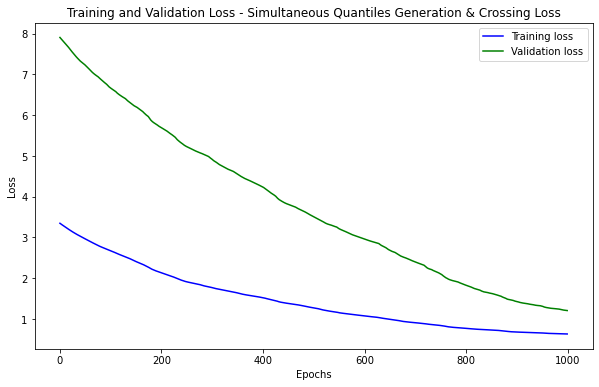

In [14]:
loss_figure(history1)

In [15]:
# with mlflow.start_run():
    
#     # Logging params and metrics to MLFlow
#     mlflow.log_param('data file', datafile)
#     if isinstance(dataset, pd.DataFrame):    
#         mlflow.log_param('features', dataset.columns)
#     else:
#         mlflow.log_param('features', "GDP")
#     mlflow.log_param('quantiles', param['QUANTILES'])
#     mlflow.log_param('learning rate', param['1_LEARNING_RATE'])
#     mlflow.log_param('lag lenght', param['WINDOW_SIZE'])
#     mlflow.log_param('split', param['SPLIT'])
#     mlflow.log_param('epochs', EPOCHS1)
#     mlflow.log_param('common LSTM units', param['1_COMMON_LSTM_NUM'])
#     mlflow.log_param('branch LSTM units', param['1_IND_LSTM_NUM'])
#     mlflow.log_param('dense layer units', param['1_IND_DENSE_NUM'])
#     mlflow.log_param('dense layer activation', param['1_IND_DENSE_ACTIVATION'])
#     mlflow.log_param('out layer activation', param['1_OUT_DENSE_ACTIVATION'])
    
#     mlflow.log_metric('loss', history1.history['loss'][-1])
#     mlflow.log_metric('mae', history1.history['mae'][-1])
#     mlflow.log_metric('mse', history1.history['mse'][-1])
#     mlflow.log_metric('val_loss', history1.history['val_loss'][-1])
#     mlflow.log_metric('val_mae', history1.history['val_mae'][-1])
#     mlflow.log_metric('val_mse', history1.history['val_mse'][-1])
#     # Logging figures
    
#     # Reshaping the output
#     if len(y_test_dist.shape) > 2:
#         y_test_dist = y_test_dist.squeeze()   
    
#     if len(y_train_dist.shape) > 2:
#         y_train_dist = y_train_dist.squeeze() 
    
#     fig1, ax1 = loss_figure(history1)
#     fig2, ax2 = train_dist_figure(y_train_dist, param['QUANTILES'], data)
#     fig3, ax3 = test_dist_figure(y_test_dist, param['QUANTILES'], data)

#     mlflow.log_figure(fig1, "loss_figure.png")
#     mlflow.log_figure(fig2, "train_dist.png")
#     mlflow.log_figure(fig3, "test_dist.png")
    
#     # Logging model to MLFlow
#     #mlflow.tensorflow.log_model(model1, 'Quantile model')

In [16]:
if len(y_test_dist.shape) > 2:
    pd_y_test_dist = pd.DataFrame(y_test_dist.squeeze()) 
else:
    pd_y_test_dist = pd.DataFrame(y_test_dist)
    
pd_y_test_dist

,0,1,2,3
0,-0.582497,-0.191850,0.367862,0.794706
1,-0.533184,-0.114696,0.330915,0.900285
2,-0.575716,-0.013402,0.549479,0.637722
3,-0.565760,-0.214538,0.274686,0.889850
4,-0.522852,-0.108438,0.376064,0.909740
5,-0.547659,-0.142063,0.280698,0.894020
6,-0.494674,-0.109101,0.294827,1.019484
7,-0.473567,-0.182135,0.186573,1.163943
8,-0.478824,-0.317910,-0.042261,1.315436
9,-0.598387,-0.196804,0.208876,0.809181


In [17]:
y_test_dist.shape

(18, 4, 1)

In [18]:
#inverted_data = invert_normalize(scaler, y_test_dist)
#pd.DataFrame(inverted_data)

In [19]:
def estimate_density_sst(data_input):
    data = [np.quantile(data_input, 0.05),
            np.quantile(data_input, 0.25),
            np.quantile(data_input, 0.75),
            np.quantile(data_input, 0.95)]
    
    initial_estimates = np.array([1., 1., 1., 3.])

    parameters_est = optimize.leastsq(opt2, initial_estimates, (data, ))
    
    dist_result = SST( 
              mu = parameters_est[0][0], 
              sigma = parameters_est[0][1], 
              nu = parameters_est[0][2],
              tau = parameters_est[0][3]
              )

    n = 2**10
    x = np.linspace(-15, 15, n)

    density = dist_result.d(x)
    median_est = dist_result.q(0.5)
    
    return density, dist_result, parameters_est, median_est

def opt2(parameters, data):
    dist = SST(mu = parameters[0], sigma = parameters[1], nu = parameters[2], tau = parameters[3])
    error = dist.q(quantiles) - data
    return error

In [20]:
from scipy import stats
from scipy import optimize
from sstudentt import SST

quantiles = [
             0.05,
             0.25,
             0.75,
             0.95]

# a list of (p,x) tuples, where P(X<x)=p
# test
#percentiles = [(0.2, 8), (0.4, 12), (0.5, 16), (0.9, 30)]
mean = []
median = []
st_dev = []
skewness = []
tailweight = []
dist_prob = []
dist_cdf = []

counter = 0
for index, row in pd_y_test_dist.iterrows():
    cond_quantiles = [row[0], row[1], row[2], row[3]]
    density, dist_result, parameters_est, median_est = estimate_density_sst(cond_quantiles)
    mean.append(float(parameters_est[0][0].squeeze()))
    st_dev.append(parameters_est[0][1])
    skewness.append(parameters_est[0][2])
    tailweight.append(parameters_est[0][3])
    median.append(float(median_est.squeeze()))
    
    dist_prob.append(dist_result.d(np.squeeze(data['Y_TEST'])[counter]))
    dist_cdf.append(dist_result.p(-0.001))
    counter += 1



/Users/myanchev/miniforge3/lib/python3.9/site-packages/sstudentt/sstudentt.py:31: RuntimeWarning: invalid value encountered in sqrt
  self.tau ** 0.5) ** -1
/Users/myanchev/miniforge3/lib/python3.9/site-packages/sstudentt/sstudentt.py:32: RuntimeWarning: invalid value encountered in sqrt
  self.m = ((2 * self.tau ** 0.5) * (self.nu - self.nu ** -1)) / (
/Users/myanchev/miniforge3/lib/python3.9/site-packages/scipy/optimize/minpack.py:476: RuntimeWarning: Number of calls to function has reached maxfev = 1000.
  warnings.warn(errors[info][0], RuntimeWarning)
/Users/myanchev/miniforge3/lib/python3.9/site-packages/sstudentt/sstudentt.py:36: RuntimeWarning: invalid value encountered in sqrt
  self.mu_0 = self.mu - (self.sigma * self.m / np.sqrt(self.s2))
/Users/myanchev/miniforge3/lib/python3.9/site-packages/sstudentt/sstudentt.py:37: RuntimeWarning: invalid value encountered in sqrt
  self.sigma_0 = self.sigma / np.sqrt(self.s2)


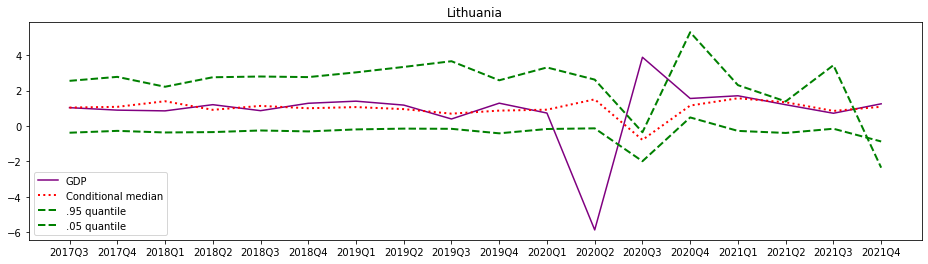

In [21]:
real_y = (data['Y_TEST'].squeeze()*scaler['std'][0] + scaler['mean'][0])*100
median = (np.array(median)*scaler['std'][0] + scaler['mean'][0])*100
s = (np.array(st_dev)*scaler['std'][0] + scaler['mean'][0])*100
lower = (pd_y_test_dist[0].squeeze()*scaler['std'][0] + scaler['mean'][0])*100
upper = (pd_y_test_dist[3].squeeze()*scaler['std'][0] + scaler['mean'][0])*100

plt.figure(figsize=[16, 4])  # inches

plt.plot(real_y.squeeze(), label='GDP', color='purple');
plt.plot(median, 'r', linewidth=2, label='Conditional median', linestyle="dotted");

plt.plot(upper, 'g', linewidth=2, label=r'.95 quantile', linestyle="--");
plt.plot(lower, 'g', linewidth=2, label=r'.05 quantile', linestyle="--");
#plt.plot(m + 2 * s, 'g', linewidth=2, label=r'mean + 2 stddev');
#plt.plot(m - 2 * s, 'g', linewidth=2, label=r'mean - 2 stddev');
#plt.plot((naive*scaler['std'][0] + scaler['mean'][0])*100, label="Naive Prediction", color='c');

ax=plt.gca();
ax.set_xticks(range(len(data['TEST_DF'])-1))
ax.set_xticklabels(data['TEST_DF'].index.to_list()[1:])
#ax.xaxis.set_ticks_position('bottom')
#ax.yaxis.set_ticks_position('left')
#ax.spines['left'].set_position(('data', 0))
#ax.spines['top'].set_visible(False)
#ax.spines['right'].set_visible(False)
#ax.spines['left'].set_smart_bounds(True)
#ax.spines['bottom'].set_smart_bounds(True)
plt.title(country)
plt.legend()
#plt.savefig('data/small_countries/charts/benchmark_'+country.lower()+'.png')

In [22]:
def denormalize(x, scaler):
    return (x*scaler['std'][0] + scaler['mean'][0])*100

In [23]:
pd_list = [pd.DataFrame(real_y.squeeze(), index = data['TEST_DF'].index.to_list()[1:]),
           pd.DataFrame(median, index = data['TEST_DF'].index.to_list()[1:]),
           pd.DataFrame(np.sqrt(np.power((real_y.squeeze()-median),2)), index = data['TEST_DF'].index.to_list()[1:]),
           pd.DataFrame(list(lower), index = data['TEST_DF'].index.to_list()[1:]),
           pd.DataFrame(list(upper), index = data['TEST_DF'].index.to_list()[1:]),
           pd.DataFrame(np.array(upper)-np.array(lower), index = data['TEST_DF'].index.to_list()[1:]),
           pd.DataFrame(denormalize(np.array(mean), scaler), index = data['TEST_DF'].index.to_list()[1:]), 
           pd.DataFrame(st_dev, index = data['TEST_DF'].index.to_list()[1:]),
           pd.DataFrame(skewness, index = data['TEST_DF'].index.to_list()[1:]),
           pd.DataFrame(tailweight, index = data['TEST_DF'].index.to_list()[1:]),
           pd.DataFrame(dist_prob, index = data['TEST_DF'].index.to_list()[1:]),
           pd.DataFrame(dist_cdf, index = data['TEST_DF'].index.to_list()[1:])]

final_df = (pd.concat(pd_list, axis=1))
final_df.set_axis(['GDP Actual', 
                   'Median',
                   'RMSE',
                   '.05 Quantile',
                   '.95 Quantile',
                   'IQR',
                   'Location', 
                   'Standard Deviation', 
                   'Skewness',
                   'Tailweight',
                   'Predictive Score', 
                   'Probability of recession'], axis=1, inplace=True)

#country = 'BG'

#final_df.to_csv('data/small_countries/'+'results_benchmark_'+country +'.csv')
#print("Exporting file to csv format at "+now.strftime('%d.%m.%Y_%H.%M.%S'))

In [24]:
list(upper)

[2.5499091148376465,
 2.774393081665039,
 2.21612286567688,
 2.752206563949585,
 2.794496774673462,
 2.761073350906372,
 3.0278382301330566,
 3.3349931240081787,
 3.6571033000946045,
 2.58068585395813,
 3.3051981925964355,
 2.619931221008301,
 -0.3514273166656494,
 5.293166160583496,
 2.30712890625,
 1.3878377676010132,
 3.4324533939361572,
 -2.350782871246338]